In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import time

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [20]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> (action -> action-values).
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # Observation ~ state
        # Stick (0) or hit (1)
        action_count = len(Q[observation])
        probs = np.zeros(action_count)
        max_action_idx = np.argmax(Q[observation], axis=0)
        for i in range(action_count):
            if i == max_action_idx:
                probs[i] = epsilon/action_count + 1 - epsilon
            else:
                probs[i] = epsilon/action_count
        return probs

    return policy_fn

In [28]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    for episode in range(num_episodes):
       # Print out which episode we're on, useful for debugging.
        if episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(episode, num_episodes), end="")
            sys.stdout.flush()

        state = env.reset()
        done = False
        actions_taken, states, rewards = [], [], []
        
        # Finish the episode
        while not done:
            actions_prob = policy(state)
            # print(actions_prob)
            # Action is either 0 (stick) or 1(hit)
            action = np.argmax(actions_prob)

            new_state, reward, done, info = env.step(action)
            actions_taken.append(action)
            states.append(state)
            rewards.append(reward)

            returns_count[state] += 1
            state = new_state

        # Update q function
        for i in range(len(actions_taken)):
            action = actions_taken[i]
            state = states[i]
            
            G_t = sum([reward * (discount_factor ** i) for i, reward in enumerate(rewards)])
            Q[state][action] = Q[state][action] + (1/returns_count[state]) * (G_t - Q[state][action]) 
        
        # Avoid division by zero
        epsilon = 1/(episode+1)
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    return Q, policy

In [31]:
start = time.clock()

Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

end = time.clock()
print("\n",end - start,"s")

Episode 499000/500000.
 68.24248100000001 s


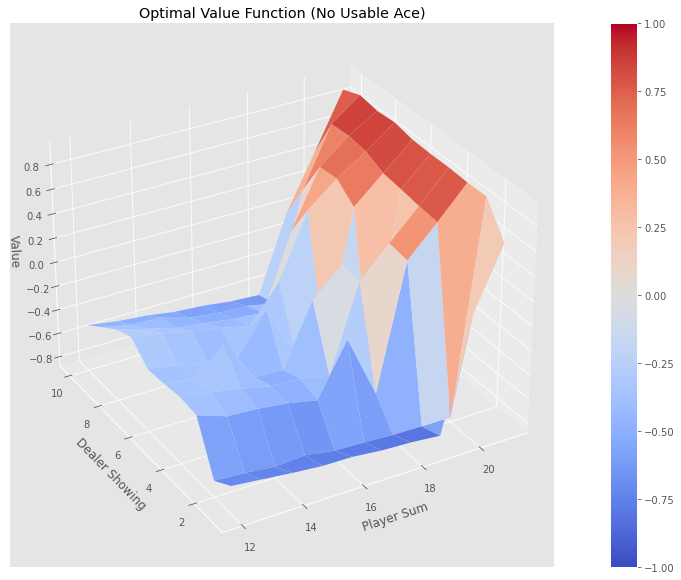

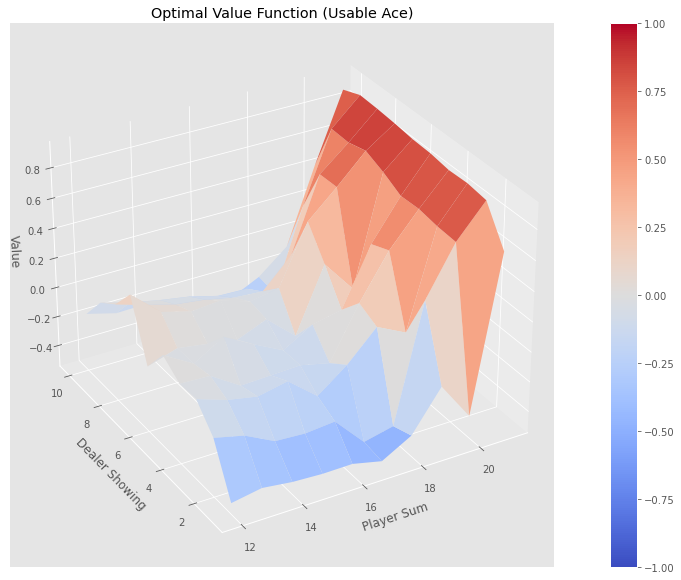

In [32]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")